In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime, date

In [2]:
# Load your CSV data
# movement_data = pd.read_csv(r"C:\Users\leeda\OneDrive - Washington State University (email.wsu.edu)\detecting-dine-out-patterns\data\movements.csv", parse_dates=["datetime"])  # Replace with your file path
# restaurant_data = pd.read_csv(r"C:\Users\leeda\OneDrive - Washington State University (email.wsu.edu)\detecting-dine-out-patterns\data\restaurants.csv")  # Replace with your file path
movement_data = pd.read_csv("../../data/movements.csv", parse_dates=["datetime"])  # Replace with your file path
restaurant_data = pd.read_csv("../../data/restaurants.csv")  # Replace with your file path

# Clean Data

In [3]:
movement_data.columns = movement_data.columns.str.lower()
restaurant_data.columns = restaurant_data.columns.str.lower()
restaurant_data.rename(columns={'restaurant id': 'restaurant_id'}, inplace=True)

# for n in movement_data:
#     movement_data["time"] = movement_data["datetime"].str.split(" ")
#print(movement_data.dtypes)

print(movement_data.head())
print(restaurant_data.head())



             datetime    id   longitude   latitude
0 2020-01-01 00:00:00  I000 -122.335167  47.608013
1 2020-01-01 00:01:07  I000 -122.335166  47.608462
2 2020-01-01 00:01:37  I000 -122.335167  47.608432
3 2020-01-01 00:02:35  I000 -122.335166  47.608682
4 2020-01-01 00:04:05  I000 -122.335166  47.608841
  restaurant_id                   name  \
0          R000   Pullman Quick Stop 0   
1          R001   Pullman Quick Stop 1   
2          R002   Pullman Department 2   
3          R003    Pullman Groceries 3   
4          R004  Pullman Supercenter 4   

                                            category   longitude   latitude  
0                                 Convenience Stores -122.435908  47.621564  
1                                 Convenience Stores -122.297377  47.649300  
2                                  Department Stores -122.338057  47.666842  
3  Supermarkets/Other Grocery (Exc Convenience) Strs -122.242926  47.587846  
4                     Warehouse Clubs & Supercenter

In [4]:
print(movement_data.isnull().sum())
print(restaurant_data.isnull().sum())

datetime     0
id           0
longitude    0
latitude     0
dtype: int64
restaurant_id    0
name             0
category         0
longitude        0
latitude         0
dtype: int64


# Exploratory Data Analysis

## How many people

In [5]:
print(len(movement_data.groupby('id')))

10


## Entries per person

In [6]:
print(movement_data.groupby('id')['datetime'].count().head(10))

id
I000    526301
I001    525745
I002    526180
I003    526591
I004    526238
I005    525837
I006    526184
I007    526330
I008    526492
I009    526170
Name: datetime, dtype: int64


## Graphs of People's Centeral Location

### Haverstine function

In [7]:
# Haversine distance function (Earth radius in kilometers)
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of Earth in kilometers
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

### Graphs

In [8]:
centroid = movement_data.groupby('id').agg({'longitude': 'mean', 'latitude': 'mean'}).reset_index()
centroid.columns = ['id', 'centroid_longitude', 'centroid_latitude']

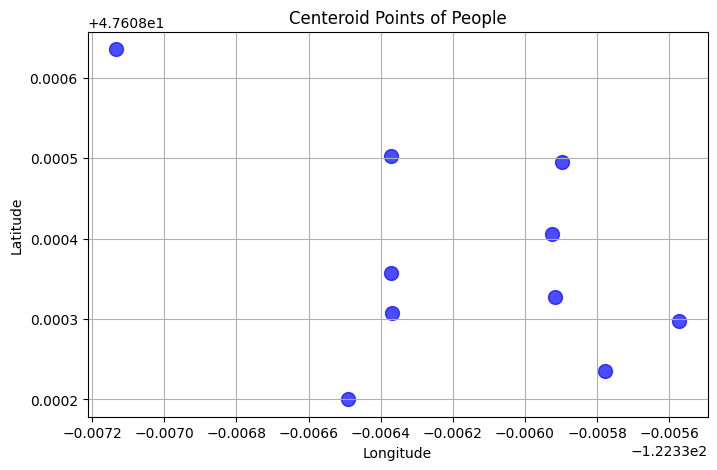

In [9]:
# Create scatter plot
plt.figure(figsize=(8, 5)) 
plt.scatter(centroid['centroid_longitude'], centroid['centroid_latitude'],label='people', color='blue', marker='o', s=100, alpha=0.7)

# Add title and labels
plt.title('Centeroid Points of People')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show grid
plt.grid(True)

# Display the plot
plt.show()

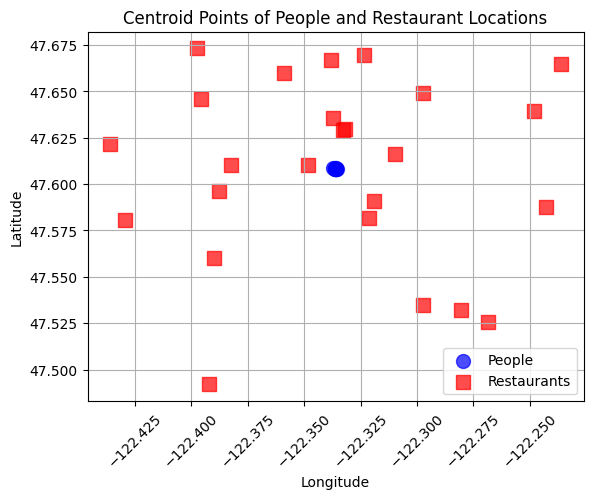

In [10]:
plt.scatter(centroid['centroid_longitude'], centroid['centroid_latitude'],label='People', color='blue', marker='o', s=100, alpha=0.7)
plt.scatter(restaurant_data['longitude'], restaurant_data['latitude'],label='Restaurants', color='red', marker='s', s=100, alpha=0.7)

# Add title and labels
plt.title('Centroid Points of People and Restaurant Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## Paths

In [11]:
person1 = movement_data[movement_data['id'] == 'I000']
person1.head()

,datetime,id,longitude,latitude
0,2020-01-01 00:00:00,I000,-122.335167,47.608013
1,2020-01-01 00:01:07,I000,-122.335166,47.608462
2,2020-01-01 00:01:37,I000,-122.335167,47.608432
3,2020-01-01 00:02:35,I000,-122.335166,47.608682
4,2020-01-01 00:04:05,I000,-122.335166,47.608841


## Average Time Between Measurements

In [12]:
movement_data['timestamp'] = pd.to_datetime(movement_data['datetime'])

# Calculate time differences
time_diffs = movement_data['timestamp'].diff()

# Compute the average time difference
average_time_diff = time_diffs.mean()

print(average_time_diff)

0 days 00:00:59.980084442


## People's Visits to Restaurants

In [29]:
movement_data = pd.read_csv("../../data/real_movements.csv", parse_dates=["datetime"])  # Replace with your file path
restaurant_data = pd.read_csv("../../data/real_restaurants.csv")  # Replace with your file path

movement_data.columns = movement_data.columns.str.lower()
restaurant_data.columns = restaurant_data.columns.str.lower()
restaurant_data.rename(columns={'restaurant id': 'restaurant_id'}, inplace=True)

def clean_restaurant_data(df):
    df.columns = df.columns.str.lower()
    df['longitude'] = df['longitude'] / 1000000 * -1
    df['latitude'] = df['latitude'] / 1000000
    return df

restaurant_data = clean_restaurant_data(restaurant_data)

In [ ]:
# Define a function to check if each movement is near a restaurant
def is_near_restaurant(movement, restaurants, threshold_km, threshold_time):
    # Ensure 'longitude' and 'latitude' exist in movement
    if 'longitude' not in movement or 'latitude' not in movement:
        raise ValueError("Movement must contain 'longitude' and 'latitude' keys.")
    
    list1 = []
    list2 = []
    list3 = []
    list4 = []
    list5 = []
    list6 = []
    list7 = []
    list8 = []

    i = 0
    # Iterate over the rows of the restaurants DataFrame
    for index, restaurant in restaurants.iterrows():
        # Calculate the distance using the haversine function
        distance = haversine(movement['longitude'], movement['latitude'], restaurant['longitude'], restaurant['latitude'])
        
        # Check if the distance is within the threshold
        n = 0
        within_restaurant = False
        for dist in distance:
            if not within_restaurant and dist <= threshold_km:
                list1.append(movement.loc[n, 'id']) 
                list2.append(movement.loc[n, 'datetime']) 
                list3.append(restaurant['restaurant_id']) 
                list4.append(dist)
                within_restaurant = True
            elif within_restaurant and dist > threshold_km:
                list5.append(movement.loc[n, 'id']) 
                list6.append(movement.loc[n, 'datetime']) 
                list7.append(restaurant['restaurant_id']) 
                list8.append(dist)
                within_restaurant = False
            n+=1
    
    dict1 = {'id':list1, 'datetime':list2, 'restaurant_id':list3, 'distance':list4}
    dict2 = {'id':list5, 'datetime':list6, 'restaurant_id':list7, 'distance':list8}
    start_times = pd.DataFrame(dict1)
    end_times = pd.DataFrame(dict2)

    list9 = []
    list10 = []
    list11 = []
    list12 = []
    list13 = []
    list14 = []
    start_times['time'] = pd.to_datetime(start_times['datetime']).dt.time
    end_times['time'] = pd.to_datetime(end_times['datetime']).dt.time
    start_times['date'] = pd.to_datetime(start_times['datetime']).dt.date
    end_times['date'] = pd.to_datetime(end_times['datetime']).dt.date
    for (index1, start), (index2, end) in zip(start_times.iterrows(), end_times.iterrows()):
       car = datetime.combine(date.today(), end['time']) - datetime.combine(date.today(), start['time'])
       sec = int(car.total_seconds())
       if sec >= threshold_time:
           list9.append(start_times.loc[index1, 'id'])
           list10.append(start_times.loc[index1, 'restaurant_id'])
           list11.append(start_times.loc[index1, 'date'])
           list12.append(start_times.loc[index1, 'time'])
           list13.append(end_times.loc[index2, 'time'])
           list14.append(sec)

    dict3 = {'id':list9, 'restaurant_id':list10, 'date':list11, 'start_time':list12, 'end_time':list13, 'total_time(seconds)':list14}
    final = pd.DataFrame(dict3)

    # return False, None  # Return False and None if no nearby restaurant is found
    return final
x = is_near_restaurant(movement_data, restaurant_data, 0.01, 300)
print(x.head())
print(len(x.index))





In [30]:
# Define a function to check if each movement is near a restaurant
def is_near_restaurant(movement, restaurants, threshold_km, threshold_time):
    # Ensure 'longitude' and 'latitude' exist in movement
    if 'longitude' not in movement or 'latitude' not in movement:
        raise ValueError("Movement must contain 'longitude' and 'latitude' keys.")
    
    list1 = []
    list2 = []
    list3 = []
    list4 = []
    list5 = []
    list6 = []
    list7 = []
    list8 = []

    i = 0
    # Iterate over the rows of the restaurants DataFrame
    for index, restaurant in restaurants.iterrows():
        # Calculate the distance using the haversine function
        distance = haversine(movement['longitude'], movement['latitude'], restaurant['longitude'], restaurant['latitude'])
        
        # Check if the distance is within the threshold
        n = 0
        within_restaurant = False
        for dist in distance:
            if not within_restaurant and dist <= threshold_km:
                list1.append(movement.loc[n, 'id']) 
                list2.append(movement.loc[n, 'datetime']) 
                list3.append(restaurant['restaurant_id']) 
                list4.append(dist)
                within_restaurant = True
            elif within_restaurant and dist > threshold_km:
                list5.append(movement.loc[n, 'id']) 
                list6.append(movement.loc[n, 'datetime']) 
                list7.append(restaurant['restaurant_id']) 
                list8.append(dist)
                within_restaurant = False
            n+=1
    
    dict1 = {'id':list1, 'datetime':list2, 'restaurant_id':list3, 'distance':list4}
    dict2 = {'id':list5, 'datetime':list6, 'restaurant_id':list7, 'distance':list8}
    start_times = pd.DataFrame(dict1)
    end_times = pd.DataFrame(dict2)

    list9 = []
    list10 = []
    list11 = []
    list12 = []
    list13 = []
    list14 = []
    start_times['time'] = pd.to_datetime(start_times['datetime']).dt.time
    end_times['time'] = pd.to_datetime(end_times['datetime']).dt.time
    start_times['date'] = pd.to_datetime(start_times['datetime']).dt.date
    end_times['date'] = pd.to_datetime(end_times['datetime']).dt.date
    for (index1, start), (index2, end) in zip(start_times.iterrows(), end_times.iterrows()):
       car = datetime.combine(date.today(), end['time']) - datetime.combine(date.today(), start['time'])
       sec = int(car.total_seconds())
       if sec >= threshold_time:
           list9.append(start_times.loc[index1, 'id'])
           list10.append(start_times.loc[index1, 'restaurant_id'])
           list11.append(start_times.loc[index1, 'date'])
           list12.append(start_times.loc[index1, 'time'])
           list13.append(end_times.loc[index2, 'time'])
           list14.append(sec)

    dict3 = {'id':list9, 'restaurant_id':list10, 'date':list11, 'start_time':list12, 'end_time':list13, 'total_time(seconds)':list14}
    final = pd.DataFrame(dict3)

    # return False, None  # Return False and None if no nearby restaurant is found
    return final
x = is_near_restaurant(movement_data, restaurant_data, 0.01, 300)
print(x.head())
print(len(x.index))





    id  restaurant_id        date start_time  end_time  total_time(seconds)
0  121      579571910  2017-12-27   01:04:57  01:10:41                  344
1  121      579571910  2017-12-27   02:38:45  02:56:41                 1076
2  121      579571910  2018-03-03   02:40:19  02:47:23                  424
3  125      529551798  2021-05-28   19:34:07  19:40:44                  397
4  125      529551798  2021-05-28   19:51:53  21:10:05                 4692
88
